In [101]:
### library
import os
import pandas as pd
import pylab as pl
import numpy as np
import matplotlib.pyplot as plt
import h5py
import scipy
import tensorflow as tf
# from PIL import Image
from scipy import ndimage

import math
from lr_utils import load_dataset
import sklearn
import sklearn.datasets
import sklearn.linear_model

%matplotlib inline

plt.rcParams['figure.figsize'] = (5.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

np.random.seed(1) # set a seed 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [103]:
# helper function

def load_dataset():
    '''
    This functions loads up the required test and train data
    '''
    train_dataset = h5py.File('datasets/train_catvnoncat.h5', "r")
    train_set_x_orig = np.array(train_dataset["train_set_x"][:]) #  train set features
    train_set_y_orig = np.array(train_dataset["train_set_y"][:]) #  train set labels

    test_dataset = h5py.File('datasets/test_catvnoncat.h5', "r")
    test_set_x_orig = np.array(test_dataset["test_set_x"][:]) #  test set features
    test_set_y_orig = np.array(test_dataset["test_set_y"][:]) #  test set labels

    classes = np.array(test_dataset["list_classes"][:]) # the list of classes
    
    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))
    
    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes


def sigmoid(z):
    '''
    This function returns the sigmoid value for a input z value
    Arguments:x -- A scalar or numpy array of any size.
    Return:s -- sigmoid(x)
    '''
    s = 1 / (1 + np.exp(-z))
    return s

def plot_decision_boundary(model, X, y):
    # Set min and max values and give it some padding
    x_min, x_max = X[0, :].min() - 1, X[0, :].max() + 1
    y_min, y_max = X[1, :].min() - 1, X[1, :].max() + 1
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole grid
    Z = model(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap= plt.cm.Spectral)
    plt.ylabel('x2')
    plt.xlabel('x1')
    plt.scatter(X[0, :], X[1, :], c=y[0,:], cmap=plt.cm.Spectral)

def load_planar_dataset():
    np.random.seed(1)
    m = 400 # number of examples
    N = int(m/2) # number of points per class
    D = 2 # dimensionality
    X = np.zeros((m,D)) # data matrix where each row is a single example
    Y = np.zeros((m,1), dtype='uint8') # labels vector (0 for red, 1 for blue)
    a = 4 # maximum ray of the flower

    for j in range(2):
        ix = range(N*j,N*(j+1))
        t = np.linspace(j*3.12,(j+1)*3.12,N) + np.random.randn(N)*0.2 # theta
        r = a*np.sin(4*t) + np.random.randn(N)*0.2 # radius
        X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
        Y[ix] = j
        
    X = X.T
    Y = Y.T

    return X, Y

def load_extra_datasets():  
    N = 200
    noisy_circles = sklearn.datasets.make_circles(n_samples=N, factor=.5, noise=.3)
    noisy_moons = sklearn.datasets.make_moons(n_samples=N, noise=.2)
    blobs = sklearn.datasets.make_blobs(n_samples=N, random_state=5, n_features=2, centers=6)
    gaussian_quantiles = sklearn.datasets.make_gaussian_quantiles(mean=None, cov=0.5, n_samples=N, n_features=2, n_classes=2, shuffle=True, random_state=None)
    no_structure = np.random.rand(N, 2), np.random.rand(N, 2)
    
    return noisy_circles, noisy_moons, blobs, gaussian_quantiles, no_structure

In [104]:
## Neural Network modules

# initialize parameters
def initialize_with_zeros(dim):
    """
    This function creates a vector of zeros of shape (dim, 1) for w and initializes b to 0.    
    Argument:dim --> size of the w vector we want (or number of parameters in this case)
    Returns: w --> initialized vector of shape (dim, 1)
             b --> initialized scalar (corresponds to the bias)
    """
    
    w = np.zeros((dim,1));  b = 0
    
    assert(w.shape == (dim, 1))
    assert(isinstance(b, float) or isinstance(b, int))
    
    return w, b

# forward and backward propagation
def propagate(w, b, X, Y):
    """
    Implement the cost function and its gradient for the propagation explained above
    Arguments:
    w -- weights, a numpy array of size (num_px * num_px * 3, 1)
    b -- bias, a scalar
    X -- data of size (num_px * num_px * 3, number of examples)
    Y -- true "label" vector (containing 0 if non-cat, 1 if cat) of size (1, number of examples)

    Return:
    L_cost -- negative log-likelihood cost for logistic regression
    dL_dw -- gradient of the loss with respect to w, thus same shape as w
    dL_db -- gradient of the loss with respect to b, thus same shape as b
    """
    
    m = X.shape[1]
    
    ## FORWARD PROPAGATION (FROM X TO COST)    
    A = sigmoid(  ( w.T @ X ) + b  )                          # compute activation    
    L_cost = -1/m * np.sum(  ( Y*np.log(A) + (1-Y)*np.log(1-A) )  )    # compute cost    
    
    # BACKWARD PROPAGATION (to find gradient)
    dL_dW = 1/m * ( X @ (A-Y).T )
    dL_dB = 1/m * np.sum(A - Y)
    
    cost = L_cost; dw = dL_dW; db = dL_dB

    assert(dw.shape == w.shape)
    assert(db.dtype == float)
    cost = np.squeeze(cost)
    assert(cost.shape == ())
    
    grads = {"dw": dw,
             "db": db}
    
    return grads, cost

def optimize(w, b, X, Y, num_iterations, learning_rate, print_cost = False):
    """
    This function optimizes w and b by running a gradient descent algorithm
    
    Arguments:
    w -- weights, a numpy array of size (num_px * num_px * 3, 1)
    b -- bias, a scalar
    X -- data of shape (num_px * num_px * 3, number of examples)
    Y -- true "label" vector (containing 0 if non-cat, 1 if cat), of shape (1, number of examples)
    num_iterations -- number of iterations of the optimization loop
    learning_rate -- learning rate of the gradient descent update rule
    print_cost -- True to print the loss every 100 steps
    
    Returns:
    params -- dictionary containing the weights w and bias b
    grads -- dictionary containing the gradients of the weights and bias with respect to the cost function - dL/dw, dL/db
    costs -- list of all the costs computed during the optimization, this will be used to plot the learning curve.
    
    Tips:
    You basically need to write down two steps and iterate through them:
        1) Calculate the cost and the gradient for the current parameters. Use propagate().
        2) Update the parameters using gradient descent rule for w and b.
        
    params, grads, costs = optimize(w, b, X, Y, num_iterations, learning_rate, print_cost=False)    
    """
    
    costs = []
    
    for i in range(num_iterations):        
        
        ## Cost and gradient calculation (≈ 1-4 lines of code) 
        grads, cost = propagate(w, b, X, Y)
        # Retrieve derivatives from grads
        dL_dw = grads["dw"]
        dL_db = grads["db"]
        
        # update rule (≈ 2 lines of code)       
        w = w - learning_rate * dL_dw
        b = b - learning_rate * dL_db
        
        # Record the every 100th costs
        if i % 100 == 0:
            costs.append(cost)
        
        # Print the cost every 100 training iterations
        if (print_cost and i % 100 == 0):
            print ("Cost after iteration %i: %f" %(i, cost))
    
    params = {"w": w,
              "b": b}
    
    dw = dL_dw; db = dL_db    
    grads = {"dw": dw,
             "db": db}
    
    return (params, grads, costs)


def predict(w, b, X):
    '''
    Predict whether the label is 0 or 1 using learned logistic regression parameters (w, b)
    
    Arguments:
    w -- weights, a numpy array of size (num_px * num_px * 3, 1)
    b -- bias, a scalar
    X -- data of size (num_px * num_px * 3, number of examples)
    
    Returns:
    Y_prediction -- a numpy array (vector) containing all predictions (0/1) for the examples in X
    '''
    
    m = X.shape[1]
    Y_prediction = np.zeros((1,m))
    w = w.reshape(X.shape[0], 1)
    
    # Compute vector "A" predicting the probabilities of a cat being present in the picture
    A = sigmoid( (  w.T @ X ) + b  )

    Y_prediction[np.where(A >= 0.5)] = 1
    Y_prediction[np.where(A <  0.5)] = 0 
    
    assert(Y_prediction.shape == (1, m))
    
    return Y_prediction

In [105]:
# integrate all modules

def model(X_train, Y_train, X_test, Y_test, num_iterations = 2000, learning_rate = 0.5, print_cost = False):
    """
    Builds the logistic regression model by integrate all modules developed previously
    
    Arguments:
    X_train -- training set represented by a numpy array of shape (num_px * num_px * 3, m_train)
    Y_train -- training labels represented by a numpy array (vector) of shape (1, m_train)
    X_test -- test set represented by a numpy array of shape (num_px * num_px * 3, m_test)
    Y_test -- test labels represented by a numpy array (vector) of shape (1, m_test)
    
    num_iterations -- hyperparameter representing the number of iterations to optimize the parameters
    learning_rate -- hyperparameter representing the learning rate used in the update rule of optimize()
    print_cost -- Set to true to print the cost every 100 iterations
    
    Returns:
    d -- dictionary containing information about the model.
    """
    
    # initialize parameters with zeros (≈ 1 line of code)
    w, b = initialize_with_zeros(dim = X_train.shape[0])

    # Gradient descent (≈ 1 line of code)
    parameters, grads, costs = optimize(w, b, X_train, Y_train,
                                        num_iterations, learning_rate, print_cost)    
    
    # Retrieve parameters w and b from dictionary "parameters"
    w = parameters["w"]
    b = parameters["b"]
    
    # Predict test/train set examples (≈ 2 lines of code)
    Y_prediction_test = predict(w,b, X=  X_test)
    Y_prediction_train = predict(w,b, X = X_train)


    # Print train/test Errors
    print("train accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_train - Y_train)) * 100))
    print("test accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_test - Y_test)) * 100))

    
    d = {"costs": costs,
         "Y_prediction_test": Y_prediction_test, 
         "Y_prediction_train" : Y_prediction_train, 
         "w" : w, 
         "b" : b,
         "learning_rate" : learning_rate,
         "num_iterations": num_iterations}
    
    return d

y = [0], it's a 'non-cat' picture.


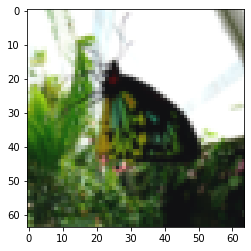

Number of training examples: m_train = 209
Number of testing examples: m_test = 50
Height/Width of each image: num_px = 64
Each image is of size: (64, 64, 3)
train_set_x shape: (209, 64, 64, 3)
train_set_y shape: (1, 209)
test_set_x shape: (50, 64, 64, 3)
test_set_y shape: (1, 50)
train_set_x_flatten shape: (12288, 209)
train_set_y shape: (1, 209)
test_set_x_flatten shape: (12288, 50)
test_set_y shape: (1, 50)
sanity check after reshaping: [17 31 56 22 33]


In [106]:
## load dataset
train_set_x_orig, train_set_y, test_set_x_orig, test_set_y, classes = load_dataset()
train_set_x_orig.shape

# Example of a picture
index = 30
plt.imshow(train_set_x_orig[16])
print ("y = " + str(train_set_y[:, index]) + ", it's a '" + classes[np.squeeze(train_set_y[:, index])].decode("utf-8") +  "' picture.")
plt.show()
# dimensions and shapes of the problem 
m_train = train_set_x_orig.shape[0]
m_test = test_set_x_orig.shape[0]
num_px = train_set_x_orig.shape[1]

print ("Number of training examples: m_train = " + str(m_train))
print ("Number of testing examples: m_test = " + str(m_test))
print ("Height/Width of each image: num_px = " + str(num_px))
print ("Each image is of size: (" + str(num_px) + ", " + str(num_px) + ", 3)")
print ("train_set_x shape: " + str(train_set_x_orig.shape))
print ("train_set_y shape: " + str(train_set_y.shape))
print ("test_set_x shape: " + str(test_set_x_orig.shape))
print ("test_set_y shape: " + str(test_set_y.shape))

## train/test set
train_set_x_flatten = train_set_x_orig.reshape(
    train_set_x_orig.shape[0],
    (train_set_x_orig.shape[1]*train_set_x_orig.shape[2]*train_set_x_orig.shape[3])
    ).T

test_set_x_flatten = test_set_x_orig.reshape(
    test_set_x_orig.shape[0],
    (test_set_x_orig.shape[1]*test_set_x_orig.shape[2]*test_set_x_orig.shape[3])
    ).T
print ("train_set_x_flatten shape: " + str(train_set_x_flatten.shape))
print ("train_set_y shape: " + str(train_set_y.shape))
print ("test_set_x_flatten shape: " + str(test_set_x_flatten.shape))
print ("test_set_y shape: " + str(test_set_y.shape))
print ("sanity check after reshaping: " + str(train_set_x_flatten[0:5,0]))

# standardize the data
train_set_x = train_set_x_flatten/255.0
test_set_x = test_set_x_flatten/255.0

In [107]:
# run the model
d = model(train_set_x, train_set_y, test_set_x, test_set_y, num_iterations = 2000, learning_rate = 0.005, print_cost = True)

Cost after iteration 0: 0.693147
Cost after iteration 100: 0.584508
Cost after iteration 200: 0.466949
Cost after iteration 300: 0.376007
Cost after iteration 400: 0.331463
Cost after iteration 500: 0.303273
Cost after iteration 600: 0.279880
Cost after iteration 700: 0.260042
Cost after iteration 800: 0.242941
Cost after iteration 900: 0.228004
Cost after iteration 1000: 0.214820
Cost after iteration 1100: 0.203078
Cost after iteration 1200: 0.192544
Cost after iteration 1300: 0.183033
Cost after iteration 1400: 0.174399
Cost after iteration 1500: 0.166521
Cost after iteration 1600: 0.159305
Cost after iteration 1700: 0.152667
Cost after iteration 1800: 0.146542
Cost after iteration 1900: 0.140872
train accuracy: 99.04306220095694 %
test accuracy: 70.0 %


y = 0, the model predicted that it is a "cat" picture.


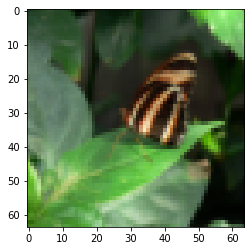

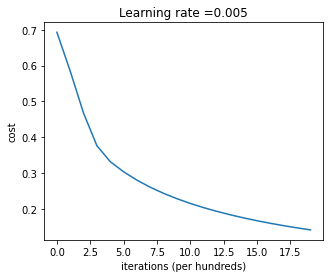

Learning rate is...0.01
train accuracy: 99.52153110047847 %
test accuracy: 68.0 %

-------------------------------------------------------

Learning rate is...0.001
train accuracy: 88.99521531100478 %
test accuracy: 64.0 %

-------------------------------------------------------

Learning rate is...0.0001
train accuracy: 68.42105263157895 %
test accuracy: 36.0 %

-------------------------------------------------------



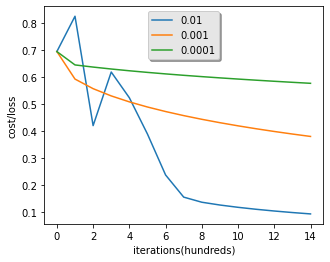

In [108]:
# Example of a picture that was wrongly classified.
index = 5
plt.imshow(test_set_x[:,index].reshape((num_px, num_px, 3)))
print ("y = " + str(test_set_y[0,index]) + ", the model predicted that it is a \"" + \
       classes[int(d["Y_prediction_test"][0,index])].decode("utf-8") +  "\" picture.")
plt.show()

# Plot: Cost @ every iteration
costs = np.squeeze(d['costs'])
plt.plot(costs)
plt.ylabel('cost')
plt.xlabel('iterations (per hundreds)')
plt.title("Learning rate =" + str(d["learning_rate"]))
plt.show()

# chossing different choice
# learning rate
alphas = [0.01, 0.001, 0.0001]

models = {}

for each_alpha in alphas:
    print("Learning rate is..." + str(each_alpha))
    models[str(each_alpha)] = model(train_set_x, train_set_y, test_set_x, test_set_y,
                                   num_iterations= 1500, learning_rate= each_alpha, print_cost= False)
    
    print ('\n' + "-------------------------------------------------------" + '\n')
    
for each_alpha in alphas:
    plt.plot(np.squeeze(models[str(each_alpha)]['costs']),
            label = str(models[str(each_alpha)]['learning_rate'])
            )
plt.ylabel('cost/loss')
plt.xlabel('iterations(hundreds)')

legend = plt.legend(loc = 'upper center', shadow= True)
frame = legend.get_frame()
frame.set_facecolor('0.90')
plt.show()

### Shallow Neural Networks

(2, 400) (1, 400)


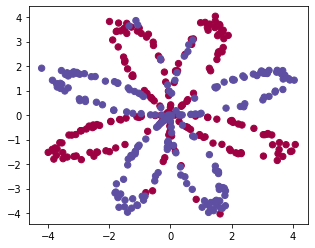

The shape of X is: (2, 400)
The shape of Y is: (1, 400)
There are m = 400 training examples


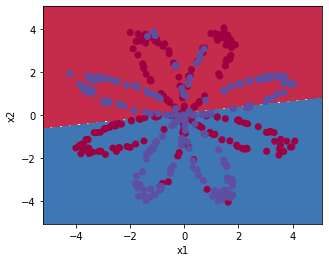

In [110]:
## data
X,Y = planar_utils.load_planar_dataset()
print(X.shape, Y.shape)

# Visualize the data
plt.scatter(X[0,:], X[1,:],
           c= Y[0,:], s= 40, cmap= plt.cm.Spectral)
plt.show()

# data info
shape_X = X.shape
shape_Y = Y.shape
m = X.shape[1]  # training set size


print ('The shape of X is: ' + str(shape_X))
print ('The shape of Y is: ' + str(shape_Y))
print ('There are m = %d training examples' % (m))


# Simple logistic regression
# Train the logistic regression classifier
# the argument needed should be such that each X varibles (X1 | X2) should be stacked horizontally column-wise ()
clf = sklearn.linear_model.LogisticRegressionCV()
# model_logis.fit(X.T, Y.T.ravel())
clf.fit(X.T, Y.T.ravel())

# plot the decision boundary of these models
planar_utils.plot_decision_boundary( lambda x: clf.predict(x), X, Y )
# plt.title('Logistic Regression')

## Neural Network model

Logistic regression did not work well on the "flower dataset". Training a Neural Network with a single hidden layer.

**Mathematically**:

For one example $x^{(i)}$:
$$z^{[1] (i)} =  W^{[1]} x^{(i)} + b^{[1]}\tag{1}$$ 
$$a^{[1] (i)} = \tanh(z^{[1] (i)})\tag{2}$$
$$z^{[2] (i)} = W^{[2]} a^{[1] (i)} + b^{[2]}\tag{3}$$
$$\hat{y}^{(i)} = a^{[2] (i)} = \sigma(z^{ [2] (i)})\tag{4}$$
$$y^{(i)}_{prediction} = \begin{cases} 1 & \mbox{if } a^{[2](i)} > 0.5 \\ 0 & \mbox{otherwise } \end{cases}\tag{5}$$

Given the predictions on all the examples, you can also compute the cost $J$ as follows: 
$$J = - \frac{1}{m} \sum\limits_{i = 0}^{m} \large\left(\small y^{(i)}\log\left(a^{[2] (i)}\right) + (1-y^{(i)})\log\left(1- a^{[2] (i)}\right)  \large  \right) \small \tag{6}$$

In [111]:
# Defining the neural network structure

def layer_sizes(X, node_num, Y):
    """
    Arguments:
    X -- input dataset of shape (input size, number of examples)
    Y -- labels of shape (output size, number of examples)
    
    Returns:
    n_x -- the size of the input layer
    n_h -- the size of the hidden layer
    n_y -- the size of the output layer
    """
    n_h = node_num
    
    n_x = X.shape[0] # size of input layer    
    n_y = Y.shape[0] # size of output layer
    
    return (n_x, n_h, n_y)

# initialization

def initialize_parameters(n_x, n_h, n_y):
    """
    Argument:
    n_x -- size of the input layer
    n_h -- size of the hidden layer
    n_y -- size of the output layer
    
    Returns:
    params -- python dictionary containing your parameters:
                    {'W1': W1, 'b1': b1, 'W2': W2, 'b2': b2}
    """
    np.random.seed(2)
    
    W1 = np.random.randn(n_h,n_x) * 0.01; b1 = np.zeros( (n_h,1) )
    W2 = np.random.randn(n_y,n_h) * 0.01; b2 = np.zeros( (n_y,1) )
    
    assert( W1.shape == (n_h,n_x) ); assert( b1.shape == (n_h,1) )
    assert( W2.shape == (n_y,n_h) ); assert( b2.shape == (n_y,1) )
    
    parameters = {'W1': W1, 'b1': b1,
                  'W2': W2, 'b2': b2}
    return (parameters)


###  `forward_propagation()`

In [116]:
def forward_propagation(X, parameters):
    """
    Argument:
    X -- input data of size (n_x, m)
    parameters -- python dictionary containing parameters (o/p of initialization function)
    
    Returns:
    A2 -- The sigmoid output of the 2nd activation
    cache -- a dictionary containing {'Z1': Z1, 'A1':A1, 'Z2':Z2  'A2':A2}
    """
    # Retrieve each value from the dictionary "parameters"
    W1 = parameters['W1']; b1 = parameters['b1']
    W2 = parameters['W2']; b2 = parameters['b2']
    
    # Forward propagation calculation
    
    
    Z1 = ( W1 @ X ) + b1
    A1 = np.tanh(Z1)
    
    Z2 = (W2 @ A1) + b2
    A2 = sigmoid(Z2)
    

    assert( A2.shape == (1,X.shape[1]) )
    
    cache = {'Z1':Z1, 'A1':A1,
             'Z2':Z2, 'A2':A2}    
    
    return (A2,cache)   

### `compute_cost()`
#### to compute the value of the cost $J$
$$J = - \frac{1}{m} \sum\limits_{i = 1}^{m} \large{(} \small y^{(i)}\log\left(a^{2 (i)}\right) + (1-y^{(i)})\log\left(1- a^{2 (i)}\right) \large{)} \small\$$

In [117]:
def compute_cost(A2,Y):
    """
    Computes the cross-entropy cost given in equation (13)
    
    Arguments:
    A2: The sigmoid output of the second activation, of shape ( 1, number of examples(m) )
    Y: "true" labels vector of shape ( 1, number of examples(m) )
    
    Returns:
    cost: cross-entropy cost given equation (13)    
    """
    
    m = Y.shape[1]
    
    # calculate cost-entropy cost 
    cost = -1/m *   np.sum(  ( Y * np.log(A2) )   +  ( (1-Y) * np.log(1-A2) )
                          )
                          
    cost = float( np.squeeze(cost) ) # makes sure the cost's dimension is turned --> [[17]] into 17 
        
    assert ( isinstance(cost,float) )
    
    return(cost)

###  `backward_propagation()`

Mathematical implementation for Backward Propagation

$\frac{\partial \mathcal{J} }{ \partial z_{2}^{(i)} } = \frac{1}{m} (a^{[2](i)} - y^{(i)})$

$\frac{\partial \mathcal{J} }{ \partial W_2 } = \frac{\partial \mathcal{J} }{ \partial z_{2}^{(i)} } a^{[1] (i) T} $

$\frac{\partial \mathcal{J} }{ \partial b_2 } = \sum_i{\frac{\partial \mathcal{J} }{ \partial z_{2}^{(i)}}}$

$\frac{\partial \mathcal{J} }{ \partial z_{1}^{(i)} } =  W_2^T \frac{\partial \mathcal{J} }{ \partial z_{2}^{(i)} } * ( 1 - a^{[1] (i) 2}) $

$\frac{\partial \mathcal{J} }{ \partial W_1 } = \frac{\partial \mathcal{J} }{ \partial z_{1}^{(i)} }  X^T $

$\frac{\partial \mathcal{J} _i }{ \partial b_1 } = \sum_i{\frac{\partial \mathcal{J} }{ \partial z_{1}^{(i)}}}$

    


In [118]:
def backward_propagation(parameters,cache, X,Y):
    """
    Implementing the backward propagation using the above method.
    
    Arguments:
    parameters -- python dictionary containing our parameters 
    cache -- a dictionary containing "Z1", "A1", "Z2" and "A2".
    X -- input data of shape (2, number of examples(m))
    Y -- "true" labels vector of shape (1, number of examples(m))
    
    Returns:
    grads -- python dictionary containing your gradients with respect to different parameters
    """
    
    m = X.shape[1]
    
    # retrieve W1 and W2 from the dictionary "parameters"
    W1 = parameters['W1'];    W2 = parameters['W2']
    
    # Retrieve A1 and A2 from dictionary "cache"
    A1 = cache['A1'];     A2 = cache['A2']
    
    # Backward propagation: calculate dL/dW1, dL/db1, dL/dW2, dL/db2
    dL_dZ2 = A2 - Y
    dL_dW2 = 1/m * ( dL_dZ2 @ A1.T )
    dL_db2 = 1/m * np.sum(dL_dZ2, axis= 1, keepdims= True)
    
    dg1_dZ1 = 1 - np.power(A1,2);  # <-- calculated this uisng calculus
    g1_ = dg1_dZ1 
    dL_dZ1 = ( W2.T @ dL_dZ2 ) * dg1_dZ1  
    dL_dW1 = 1/m * (dL_dZ1 @ X.T)
    dL_db1 = 1/m * np.sum(dL_dZ1, axis= 1, keepdims= True)
    
    
    dW1 = dL_dW1; db1 = dL_db1
    dW2 = dL_dW2; db2 = dL_db2
    grads = {'dW1':dW1, 'db1':db1,
             'dW2':dW2, 'db2':db2}
    
    return(grads)    

### Applying Gradient Descent for minimizing the cost

**Gradient descent Mathematics**: $ \theta = \theta - \alpha \frac{\partial J }{ \partial \theta }$ <br>where $\alpha$ is the learning rate and $\theta$ represents a parameter.



In [119]:
def update_parameters(parameters,grads,learning_rate= 1.2 ):
    '''
    Updates parameters using the gradient descent update rule given above
    
    Arguments:
    parameters -- python dictionary containing your parameters 
    grads -- python dictionary containing your gradients 
    
    Returns:
    parameters -- python dictionary containing your updated parameters 
    '''
    
    # Retrieve each parameter from the dictionary "parameters"
    W1 = parameters['W1']; b1 = parameters['b1']
    W2 = parameters['W2']; b2 = parameters['b2']    
    # Retrieve each gradient from the dictionary "grads"
    
    dL_W1 = grads['dW1']; dL_b1 = grads['db1']
    dL_W2 = grads['dW2']; dL_b2 = grads['db2']    
    
    # Update rule for each parameter
    W1 = W1 - learning_rate * dL_W1;    b1 = b1 - learning_rate * dL_b1
    W2 = W2 - learning_rate * dL_W2;    b2 = b2 - learning_rate * dL_b2      
    
    parameters = { "W1": W1, "b1": b1,
                   "W2": W2, "b2": b2
                 }
    
    return (parameters)
    

In [120]:
# Integrating modules to build the Neural Network

def nn_model(X, Y, n_h, num_iterations = 10000, print_cost=False):
    '''
    Arguments:
    X -- dataset of shape (2, number of examples)
    Y -- labels of shape (1, number of examples)
    n_h -- size of the hidden layer
    num_iterations -- Number of iterations in gradient descent loop
    print_cost -- if True, print the cost every 1000 iterations
    
    Returns:
    parameters -- parameters learnt by the model. They can then be used to predict.
    '''
    
    np.random.seed(3)
    
    # i/p layer sizes
    n_x, n_h, n_y = layer_sizes(X, n_h, Y)

    # initialization
    parameters = initialize_parameters(n_x, n_h, n_y)
    
    # loop for Gradient Descent
    
    for i in range(0, num_iterations):
        # Forward propagation | Inputs: X, parameters | Outputs: A2, cache
        A2, cache = forward_propagation(X, parameters)
        
        # Cost function  | Inputs: A2, Y, parameters  | Outputs: cost
        cost = compute_cost(A2,Y)
        
        # Backpropagation  | Inputs: parameters, cache, X, Y  | Outputs: grads
        grads = backward_propagation(parameters, cache, X, Y)
        
        # Gradient descent parameter update | Inputs: parameters, grads | Outputs: parameters
        parameters = update_parameters(parameters, grads)       
        
        
        # Print the cost every 1000 iterations
        if print_cost and i%1000 == 0:
            print( 'Cost after iteration %i: %f' %(i,cost) )
        
    return (parameters)


### `predict()`

Use forward propagation to predict results.

predictions = $y_{prediction} = \mathbb 1 \text{{activation > 0.5}} = \begin{cases}
      1 & \text{if}\ activation > 0.5 \\
      0 & \text{otherwise}
    \end{cases}$

In [121]:
def predict(parameters, X):
    '''
    Using the learned parameters, predicts a class for each example in X
    
    Arguments:
    parameters -- python dictionary containing your parameters 
    X -- input data of size (n_x, m)
    
    Returns:
    predictions -- vector of predictions of our model (red: 0 / blue: 1)
    '''
    
    # Computes probabilities using forward propagation, and classifies to 0/1 using 0.5 as the threshold.
    A2, cache = forward_propagation(X, parameters)
    y_hat = np.zeros((A2.shape))
    y_hat [np.where(A2 >= 0.5)] = 1  ;    y_hat [np.where(A2 < 0.5)] = 0
    
    predictions = y_hat
    return (predictions)  

Cost after iteration 0: 0.693048
Cost after iteration 1000: 0.288083
Cost after iteration 2000: 0.254385
Cost after iteration 3000: 0.233864
Cost after iteration 4000: 0.226792
Cost after iteration 5000: 0.222644
Cost after iteration 6000: 0.219731
Cost after iteration 7000: 0.217504
Cost after iteration 8000: 0.219504
Cost after iteration 9000: 0.218571


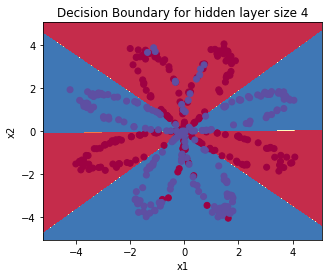

Accuracy:  [[90.75]] %


In [123]:
# running the model on planar dataset

# Build a model with a n_h-dimensional hidden layer
X,Y = load_planar_dataset()
parameters = nn_model(X, Y, n_h= 4, num_iterations=10000, print_cost= True)
# Plot the decision boundary
plot_decision_boundary(lambda x: predict(parameters, x.T), X, Y)
plt.title("Decision Boundary for hidden layer size " + str(4))
plt.show()

# accuracy
predictions = predict(parameters, X)
accuracy_value = ( (Y @ predictions.T) + ( (1-Y) @ (1-predictions.T) ) ) / Y.size*100
print ('Accuracy: ',  accuracy_value , '%')

Accuracy for 1 hidden units: 67.5 %
Accuracy for 2 hidden units: 67.25 %
Accuracy for 3 hidden units: 90.75 %
Accuracy for 4 hidden units: 90.5 %
Accuracy for 5 hidden units: 91.25 %
Accuracy for 20 hidden units: 90.0 %
Accuracy for 50 hidden units: 90.75 %


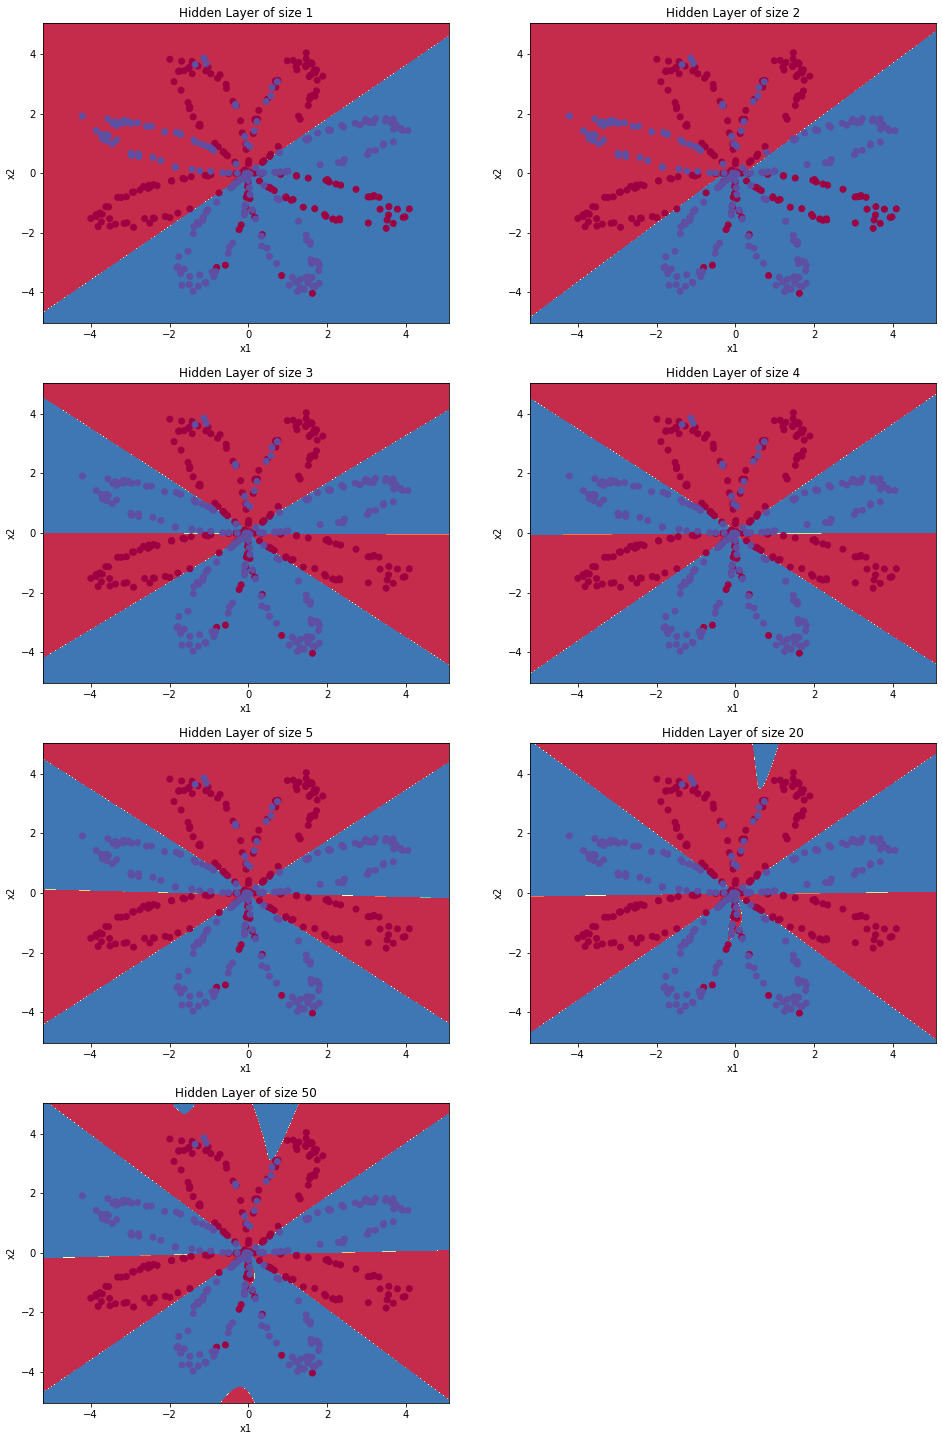

In [124]:
# running the model using differnt no. of hidden layers
plt.figure(figsize=(16, 32))
hidden_layer_sizes = [1, 2, 3, 4, 5, 20, 50]

for i, n_h in enumerate(hidden_layer_sizes):
    plt.subplot(5, 2, i+1)
    plt.title('Hidden Layer of size %d' % n_h)
    parameters = nn_model(X, Y, n_h, num_iterations = 5000)
    plot_decision_boundary(lambda x: predict(parameters, x.T), X, Y)
    predictions = predict(parameters, X)
    accuracy = float(
                    ( (Y @ predictions.T) + ( (1-Y) @ (1-predictions.T) ) ) / float(Y.size)*100
                    )
    print ("Accuracy for {} hidden units: {} %".format(n_h, accuracy))

Cost after iteration 0: 0.692992
Cost after iteration 1000: 0.167137
Cost after iteration 2000: 0.069092
Cost after iteration 3000: 0.063716
Cost after iteration 4000: 0.061312
Cost after iteration 5000: 0.059669
Cost after iteration 6000: 0.058364
Cost after iteration 7000: 0.057279
Cost after iteration 8000: 0.056359
Cost after iteration 9000: 0.055569


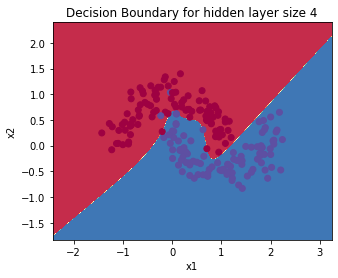

In [125]:
## Running the model for different dataset

# data
noisy_circles, noisy_moons, blobs, gaussian_quantiles, no_structure = load_extra_datasets()

datasets = {"noisy_circles": noisy_circles,
            "noisy_moons": noisy_moons,
            "blobs": blobs,
            "gaussian_quantiles": gaussian_quantiles}

# for noisy_moons data
dataset = "noisy_moons"

X, Y = datasets[dataset]
X, Y = X.T, Y.reshape(1, Y.shape[0])

# make blobs binary
if dataset == "blobs":
    Y = Y%2

# Visualize the data
plt.scatter(X[0, :], X[1, :], c=Y[0,:], s=40, cmap=plt.cm.Spectral);

# run the model
parameters = nn_model(X, Y, n_h= 4, num_iterations=10000, print_cost= True)

# Plot the decision boundary
plot_decision_boundary(lambda x: predict(parameters, x.T), X, Y)
plt.title("Decision Boundary for hidden layer size " + str(4))
plt.show()

Cost after iteration 0: 0.693146
Cost after iteration 1000: 0.423984
Cost after iteration 2000: 0.418646
Cost after iteration 3000: 0.416476
Cost after iteration 4000: 0.416774
Cost after iteration 5000: 0.415466
Cost after iteration 6000: 0.414439
Cost after iteration 7000: 0.413411
Cost after iteration 8000: 0.412453
Cost after iteration 9000: 0.411850


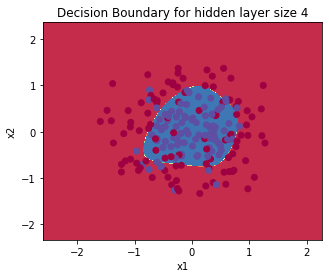

In [126]:
## Running the model for different dataset

# data
noisy_circles, noisy_moons, blobs, gaussian_quantiles, no_structure = load_extra_datasets()

datasets = {"noisy_circles": noisy_circles,
            "noisy_moons": noisy_moons,
            "blobs": blobs,
            "gaussian_quantiles": gaussian_quantiles}

# for noisy_moons data
dataset = "noisy_circles"

X, Y = datasets[dataset]
X, Y = X.T, Y.reshape(1, Y.shape[0])

# make blobs binary
if dataset == "blobs":
    Y = Y%2

# Visualize the data
plt.scatter(X[0, :], X[1, :], c=Y[0,:], s=40, cmap=plt.cm.Spectral);

# run the model
parameters = nn_model(X, Y, n_h= 4, num_iterations=10000, print_cost= True)

# Plot the decision boundary
plot_decision_boundary(lambda x: predict(parameters, x.T), X, Y)
plt.title("Decision Boundary for hidden layer size " + str(4))
plt.show()

Cost after iteration 0: 0.693158
Cost after iteration 1000: 0.097144
Cost after iteration 2000: 0.072427
Cost after iteration 3000: 0.070189
Cost after iteration 4000: 0.067819
Cost after iteration 5000: 0.065786
Cost after iteration 6000: 0.154121
Cost after iteration 7000: 0.066218
Cost after iteration 8000: 0.080391
Cost after iteration 9000: 0.065268


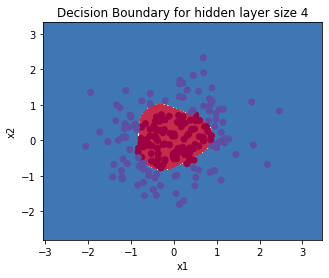

In [129]:
## Running the model for different dataset

# data
noisy_circles, noisy_moons, blobs, gaussian_quantiles, no_structure = load_extra_datasets()

datasets = {"noisy_circles": noisy_circles,
            "noisy_moons": noisy_moons,
            "blobs": blobs,
            "gaussian_quantiles": gaussian_quantiles}

# for noisy_moons data
dataset = "gaussian_quantiles"

X, Y = datasets[dataset]
X, Y = X.T, Y.reshape(1, Y.shape[0])

# make blobs binary
if dataset == "blobs":
    Y = Y%2

# Visualize the data
plt.scatter(X[0, :], X[1, :], c=Y[0,:], s=40, cmap=plt.cm.Spectral);

# run the model
parameters = nn_model(X, Y, n_h= 4, num_iterations=10000, print_cost= True)

# Plot the decision boundary
plot_decision_boundary(lambda x: predict(parameters, x.T), X, Y)
plt.title("Decision Boundary for hidden layer size " + str(4))
plt.show()